# Poisson equation in a multi-patch domain

In [1]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt
import itertools

np.set_printoptions(linewidth=100000)

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology, adaptive
from pyiga import assemble_cy

In [2]:
# define discretization space (we may choose nested discretization spaces)
p = 3
N = 10
kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),)]

In [3]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(np.pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-np.pi/2).translate((-2, 1))
]

patches = [(kv, g) for kv,g in zip(kvs,geos)]

In [4]:
# source term f and Dirichlet boundary function g
f  = lambda x, y: np.exp(-5 * ((x-0.3)**2 + (y-1)**2))
gD = lambda x, y: 1e-1 * np.sin(8*x)

# Robin boundary data such that \partial_n u + alpha * u = g1, if alpha=0 this represents also a Neumann boundary condition.
gN = lambda x, y: 0.
alpha = lambda x, y: 0.

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({'Neumann/Robin':{(0,'left'),(2,'right'),(3,'left'),(3,'right')},
                   'Dirichlet':{(0,'bottom'),(0,'right'),(1,'top'),(2,'bottom'),(2,'left'),(3,'bottom')}})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("inner(grad(u), grad(v)) * dx", arity = 2)
Fh = MP.assemble_volume("f * v * dx", arity=1, physical=True, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann/Robin')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Neumann/Robin')

setting up constraints took 0.004990100860595703 seconds.
Basis setup took 0.0022821426391601562 seconds


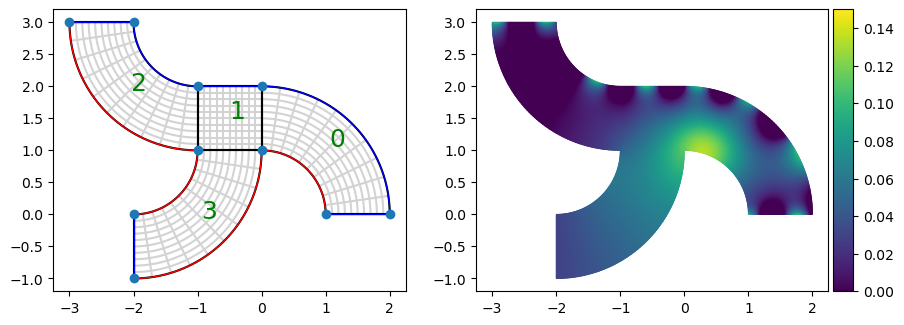

In [5]:
# set up and solve linear system by eliminating Dirichlet DoFs from the system
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

# restrict solution to each individual patch (kvs on every patch) and visualize solution together with the mesh
fig, ax = plt.subplots(1,2,figsize=(10,5))
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann/Robin':'red'}, axis=ax[0])
MP.plot(u, range = (0, 1.5e-1),cbar=True, cmap='viridis', axis=ax[1], aspect='equal', cbar_width=0.2, cbar_pad = 0.05);
ax[0].axis('scaled'); #ax[1].axis('scaled');

# Computerchip

In [22]:
# define geometry
def ComputerChip(p, N):
    geos = [
        geometry.Quad(np.array([[0,0.5,0.35, 0.5],[0,0,0.3,0.15]])),
        geometry.Quad(np.array([[0, 0.35, 0, 0.17],[0, 0.3, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.35, 0.5, 0.17, 0.5],[0.3, 0.45, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.17, 0.5, 0.17, 0.5],[0.6, 0.6, 0.8, 0.8]])),
        geometry.Quad(np.array([[0.5,1,0.5, 0.65],[0,0,0.15,0.3]])),
        geometry.Quad(np.array([[1,1,0.65,0.83],[0,0.6,0.3,0.6]])),
        geometry.Quad(np.array([[0.5,0.65,0.5,0.83],[0.45,0.3,0.6,0.6]])),
        geometry.Quad(np.array([[0.5, 0.83, 0.5, 0.83],[0.6, 0.6, 0.8, 0.8]])),
    ]

    kvs = 8 * [2 * (bspline.make_knots(p, 0.0, 1.0, N),)]
    
    patches = [(kv, g) for kv,g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    
    M.set_boundary_id({'Dirichlet':{(0,'top'),(2,'bottom'),(4,'top'),(6,'bottom')},
                       'Neumann':{(1,'top'),(1,'left'),(3,'top'),(3,'left'),(5,'bottom'),(5,'right'),(7,'top'),(7,'right')},
                       'Robin' : {(0,'bottom'),(4,'bottom')}})
    M.set_domain_id({0:{0,1,2,4,5,6}, 1:{3,7}})
    return M

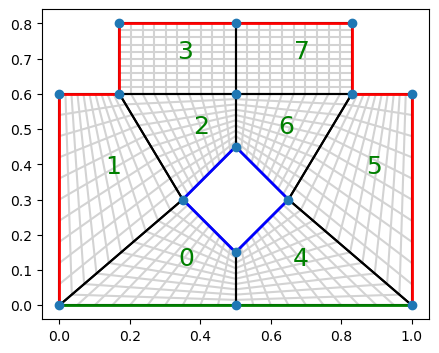

In [23]:
M = ComputerChip(3,10)

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
plt.axis('scaled');

In [25]:
kappa = 130.0
alpha = 0.2
f = lambda x,y: 0.0
gN = lambda x,y: 0.0
gD = lambda x,y: 500.0
gR = lambda x,y: 300.0*alpha
lambda0 = 0.01
lambda1 = 3.95

In [26]:
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

setting up constraints took 0.034729957580566406 seconds.
Basis setup took 0.006954669952392578 seconds


In [27]:
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

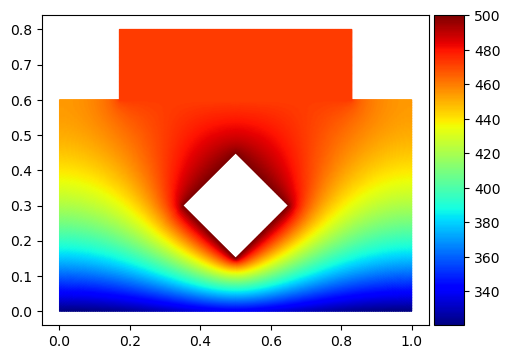

In [28]:
MP.plot(u, cbar=True, cmap='jet', aspect='equal', figsize=(5,5), physical=True);

# Using non-matching multi-patch domains for adaptive refinement

In [29]:
def solveChip(MP):
    Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
    Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

    Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')
    Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
    Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

    LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
    return LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

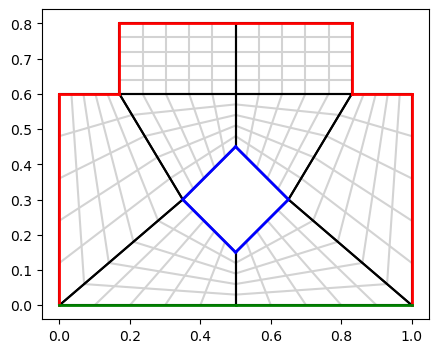

setting up constraints took 0.012904882431030273 seconds.
Basis setup took 0.0024175643920898438 seconds
Residual contributions took 0.0512 seconds.
Jump contributions took 0.0439 seconds.


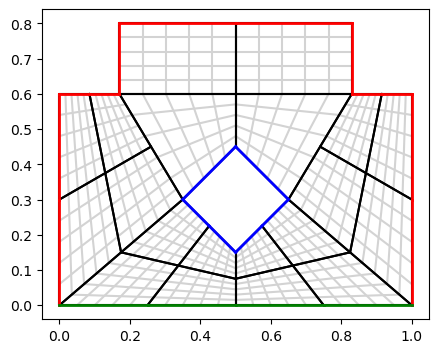

setting up constraints took 0.04313468933105469 seconds.
Basis setup took 0.0027303695678710938 seconds
Residual contributions took 0.128 seconds.
Jump contributions took 0.16 seconds.


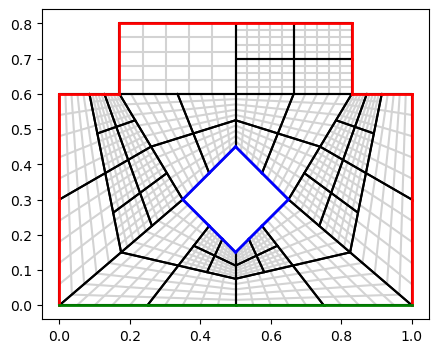

setting up constraints took 0.11743807792663574 seconds.
Basis setup took 0.003772735595703125 seconds
Residual contributions took 0.307 seconds.
Jump contributions took 0.469 seconds.


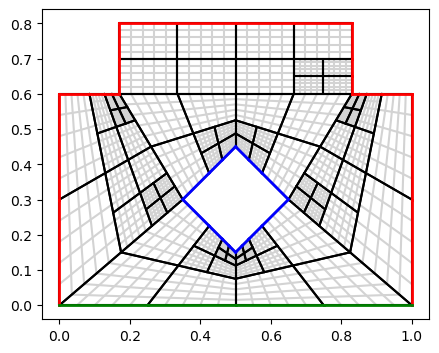

setting up constraints took 0.20228171348571777 seconds.
Basis setup took 0.004069328308105469 seconds
Residual contributions took 0.474 seconds.
Jump contributions took 0.806 seconds.


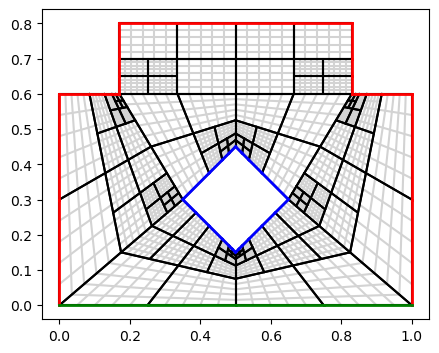

setting up constraints took 0.2974264621734619 seconds.
Basis setup took 0.004769086837768555 seconds
Residual contributions took 0.686 seconds.
Jump contributions took 1.18 seconds.


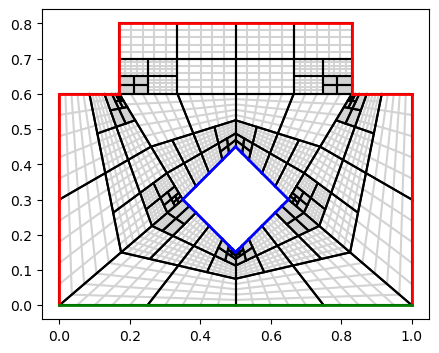

setting up constraints took 0.39955854415893555 seconds.
Basis setup took 0.005421876907348633 seconds
Residual contributions took 0.912 seconds.
Jump contributions took 1.58 seconds.


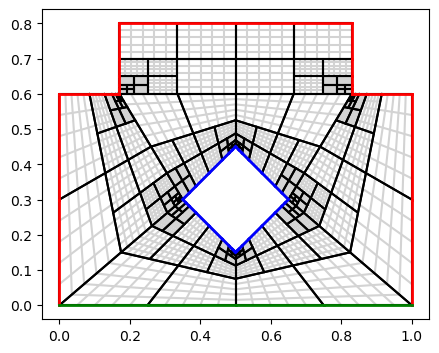

setting up constraints took 0.5129084587097168 seconds.
Basis setup took 0.00631260871887207 seconds
Residual contributions took 1.16 seconds.
Jump contributions took 2.02 seconds.


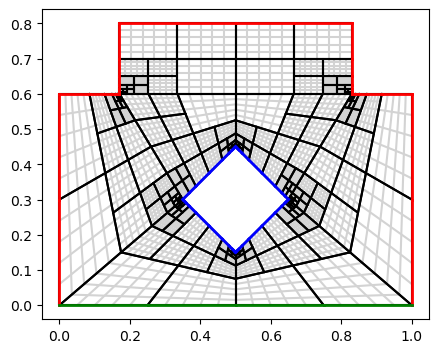

setting up constraints took 0.6287808418273926 seconds.
Basis setup took 0.006888628005981445 seconds
Residual contributions took 1.39 seconds.
Jump contributions took 2.49 seconds.


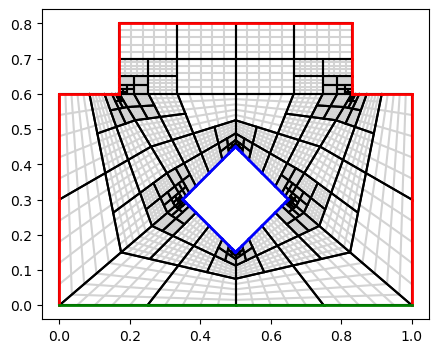

setting up constraints took 0.7530834674835205 seconds.
Basis setup took 0.007744550704956055 seconds
Residual contributions took 1.65 seconds.
Jump contributions took 3.08 seconds.


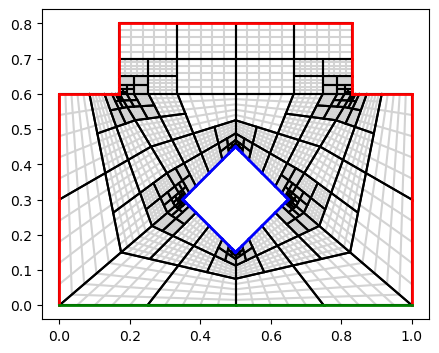

setting up constraints took 0.8831825256347656 seconds.
Basis setup took 0.008497476577758789 seconds
Residual contributions took 1.93 seconds.
Jump contributions took 3.6 seconds.


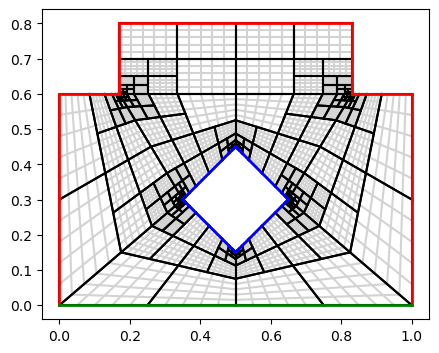

setting up constraints took 1.0111560821533203 seconds.
Basis setup took 0.009407997131347656 seconds
Residual contributions took 2.21 seconds.
Jump contributions took 4.12 seconds.


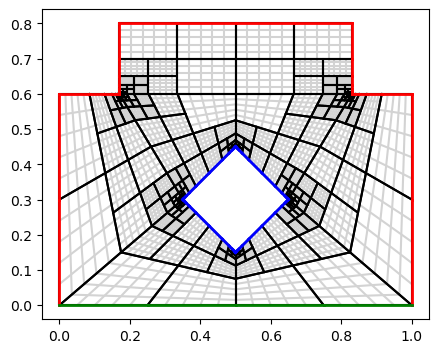

setting up constraints took 1.14910888671875 seconds.
Basis setup took 0.010651350021362305 seconds
Residual contributions took 2.48 seconds.
Jump contributions took 4.61 seconds.


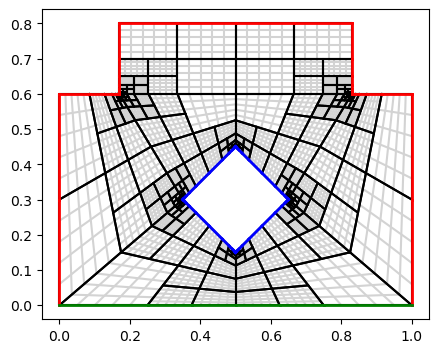

setting up constraints took 1.306894302368164 seconds.
Basis setup took 0.013948917388916016 seconds
Residual contributions took 2.83 seconds.
Jump contributions took 5.2 seconds.


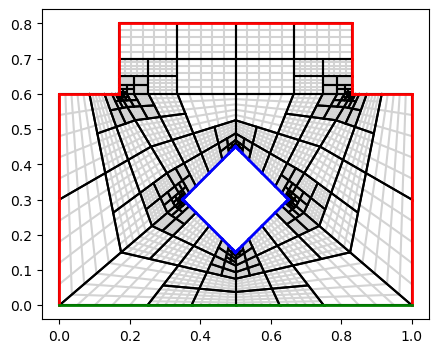

setting up constraints took 1.4673943519592285 seconds.
Basis setup took 0.012283563613891602 seconds
Residual contributions took 3.17 seconds.
Jump contributions took 5.84 seconds.


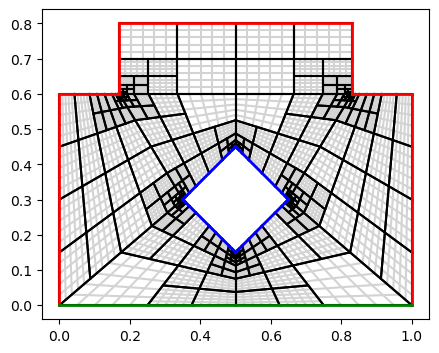

setting up constraints took 1.6830990314483643 seconds.
Basis setup took 0.013628005981445312 seconds
Residual contributions took 3.68 seconds.
Jump contributions took 6.86 seconds.


In [34]:
M = ComputerChip(3,5)

kappa = 130.0
alpha = 0.2
f = lambda x,y: 0.0
gN = lambda x,y: 0.0
gD = lambda x,y: 500.0
gR = lambda x,y: 300.0*alpha
lambda0 = 0.01
lambda1 = 3.95

maxiter=15
for it in range(maxiter):
    M.plotmesh(figsize=(5,5),patch_idx = False, knots=True, nodes=False, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
    plt.axis('scaled');
    plt.show()

    MP = assemble.Multipatch(M, automatch=True)
    dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

    #assemble and solve
    u = solveChip(MP)

    #estimate
    err_ind = adaptive.mp_resPois(MP,u,a={0:lambda0, 1:lambda1}, f={0:f, 1:f})

    #mark
    marked_patches = adaptive.quick_mark(err_ind, theta=0.95)

    #refine
    if it != maxiter-1:
        M.h_refine(patches=marked_patches,ref="rs");